<img align="right" src="../../additional_data/banner_siegel.png" style="width:1100px;">

# Parallel processing with Dask

* [**Sign up to the JupyterHub**](https://www.phenocube.org/) to run this notebook interactively from your browser
* **Compatibility:** Notebook currently compatible with the Open Data Cube environments of the University of Wuerzburg
* **Products used**: 
* **Prerequisites**:  Users of this notebook should have a basic understanding of:
    * How to run a [Jupyter notebook](01_jupyter_introduction.ipynb)
    * The basic structure of the eo2cube [satellite datasets](02_eo2cube.ipynb)
    * How to browse through the available [products and measurements](03_products_and_measurements.ipynb) of the eo2cube datacube 
    * How to [load data from the eo2cube datacube](04_loading_data_and_basic_xarray.ipynb)
    * How the data is stored and structured in a [xarray](05_advanced_xarray.ipynb)
    * How to [visualize the data](06_plotting.ipynb)
    * How to do a [basic analysis of remote sensing data](07_basic_analysis.ipynb) in the eo2cube environment

## Description
This notebook builds upon the notebook 07_basic_analysis. In that notebook we presented a sample workflow for spatial data processing. In this notebook, we will perform a partially similar workflow. The main difference is that we will perform the calculation using the dask. The following workflow will be applied:
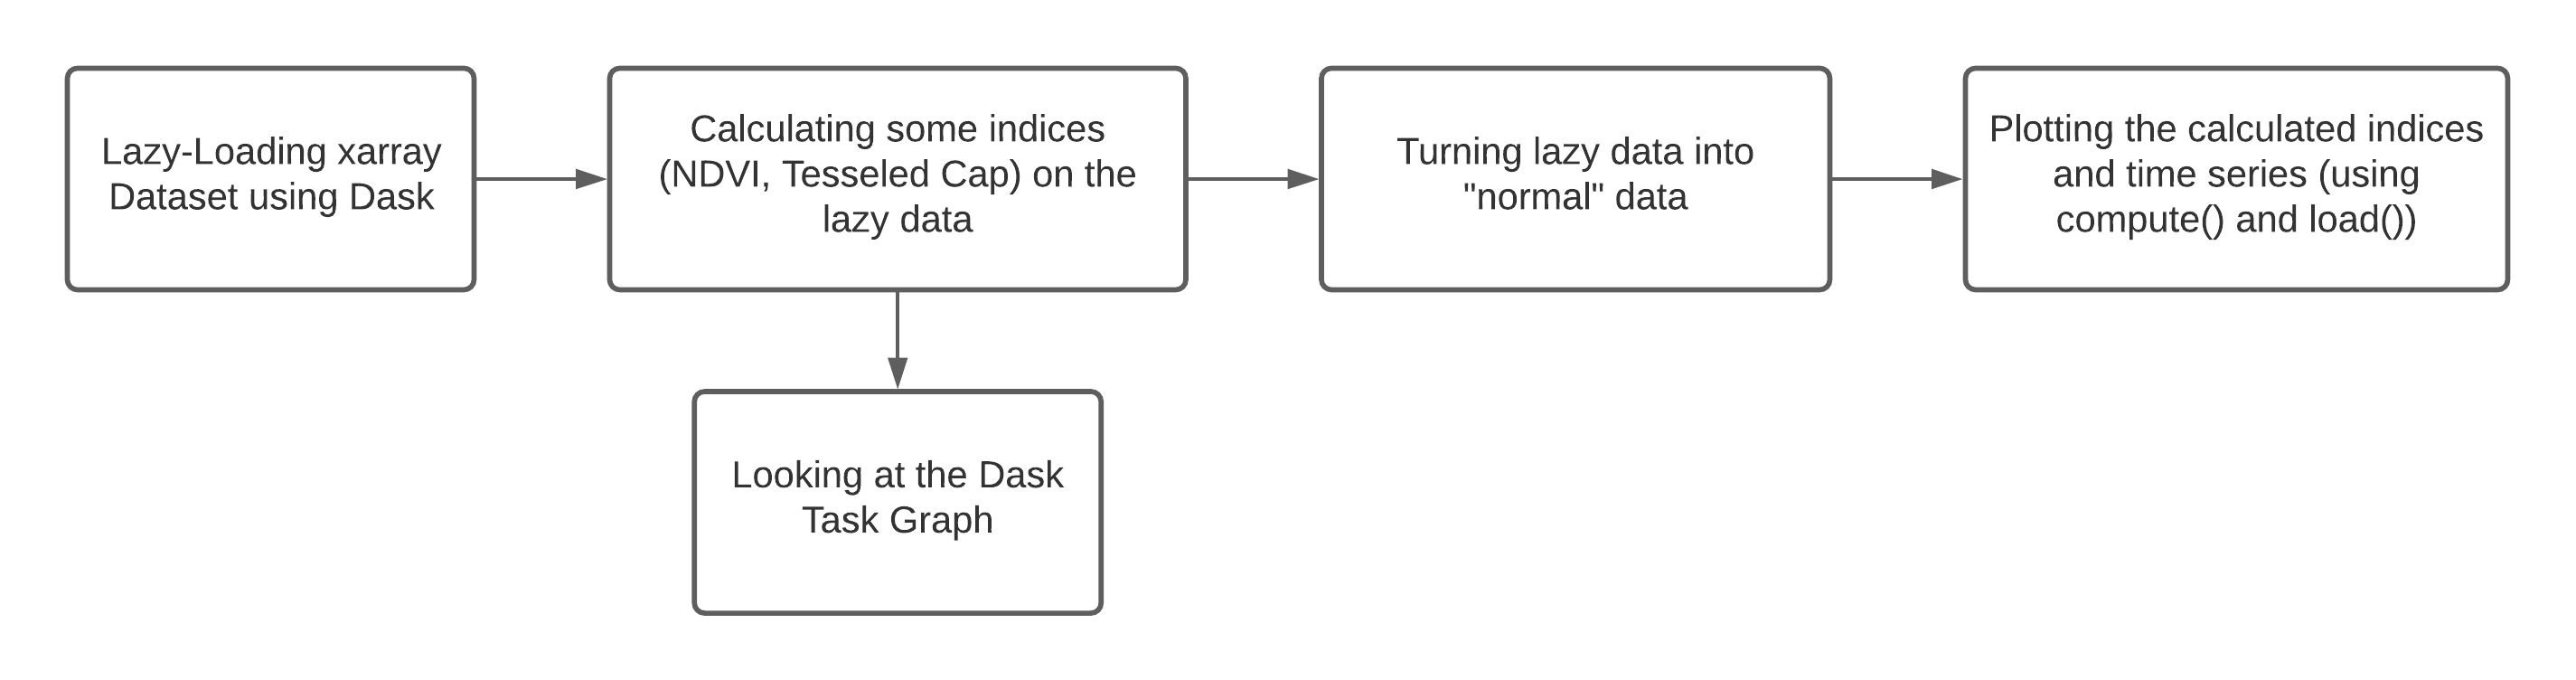

## What is Dask?
[Dask](https://dask.org/) is a library for parallel computing. It can be used to scale Pandas, NumPy, and Scikit-Learn workflows. Originally, datasets created with those libraries can only be scaled on a single machine. Dask internally uses the structures of Pandas, Numpy and Scikit-Learn. Thus, if you are familiar with those libraries, it will be easy to transform your "old" code in a new, scalable dask-version of it. <br>
In this notebook, we will mainly work with [daskArray](https://docs.dask.org/en/latest/array.html) which is the dask-equivalent to NumPy ndarray.

## Package import and datacube connection

First of all we start with importing all the packages that are needed for our analysis.<br>
Most of the packages have already been introduced in the previous notebooks. The newly introduced package here is Dask.

In [1]:
import datacube

# dask
import dask
from dask.distributed import Client

# plotting
import graphviz

# images
import matplotlib.pyplot as plt
import pandas as pd

Connecting to the datacube

In [2]:
dc = datacube.Datacube(app = '08_parallel_processing_with_dask', config = '/home/datacube/.datacube.conf')

## Dask Schedulers
### (Single machine scheduler vs. Distributed scheduler)
Dask can be used to scale computations across multiple computers (cluster). <br>
But it also can be used for parallel computing on a single computer. This enables computations that normally would have been too demanding for the used machine.<br>
For the following analysis we are using the distributed scheduler since we are working on a datacube.<br>

## Setting up Dask.distributed

To start the Dask Client, we use the Dask-plugin within the Phenocube.
To use it, just click on the orange Dask symbol on the left side of the window. Then click on the "+ New" Button. A new LocalCluster is created. <br> By clicking on the "Scale" button, the Client can be scaled (i.e. reducing the number of workers). <br>
Now, just drag and drop the Cluster into this code and reduce the number of workers to 2.

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:44027")
client

Client Scheduler: tcp://127.0.0.1:44027 Dashboard: http://127.0.0.1:33213/status,Cluster Workers: 1 Cores: 5 Memory: 23.77 GB


## Loading the data using dask
In the following, the data is loaded.
As you remeber from the previous notebooks a "normal" command for loading data looks somewhat like this: <br>
`
ds = dc.load(product = "s2_l2a_bavaria",
             measurements = ["blue", "green","red", "red_edge2", "nir", "narrow_nir"],
             longitude = [12.493, 12.509],
             latitude = [47.861, 47.868],
             time = ("2020-04-01", "2021-03-31"))
`
<br>
For loading data with dask, you just add the "dask_chunks"-parameter. <br>
This looks like this:

In [4]:
# Load Data
ds = dc.load(product = "s2_l2a_burkinafaso",
             #product = "s2_l2a_bavaria",
             #measurements = ["blue", "green","red", "red_edge2", "nir", "narrow_nir"], #bavaria
             measurements = ["blue", "green", "red", "veg6", "nir", "narrow_nir"], #burkina faso
             #longitude = [12.493, 12.509], #bavaria
             #latitude = [47.861, 47.868], #bavaria
             longitude = [-3.1438, -2.83713], #burkina faso
             latitude = [11.0745, 11.36368], #burkina faso
             #time = ("2019-01-01", "2020-04-30"), #bavaria
             time = ("2019-01-01", "2019-12-31"),
             #dask_chunks={"time": 1, "x": 50, "y": 50} #bavaria
             dask_chunks={"time": 1, "latitude": 50, "longitude":50} #burkina faso
            )

In [5]:
dc.list_products()

,name,description,lat,creation_time,instrument,lon,product_type,label,time,format,platform,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
44,S1_GRD_index,Gamma Naught RTC backscatter,None,None,C-SAR,None,gamma0,None,None,GTiff,SENTINEL-1,NaN,NaN,NaN,NaN
39,dsm1sv10,DSM 1sec Version 1.0,None,None,SIR,None,DEM,None,None,NETCDF,Space Shuttle Endeavour,NaN,NaN,NaN,NaN
40,dsm1sv10_burkinafaso,Elevation data from the Shuttle Radar Topograp...,None,None,SIR,None,DEM,None,None,NetCDF,Space Shuttle Endeavour,EPSG:4326,"(0.00027777777776258203, 0.00027777777776258203)","(0.333332761149, 0.333332761149)","(latitude, longitude)"
42,gpm_imerg_gis_daily,GIS translation of the imerg data product. Mul...,None,None,GPM,None,daily,None,None,GeoTiff,GPM,NaN,NaN,NaN,NaN
43,gpm_imerg_gis_daily_global,Global NetCDF GPM IMERG GIS data,None,None,GPM,None,daily,None,None,NetCDF,GPM,EPSG:4326,"(-0.1, 0.1)","(90, 180)","(latitude, longitude)"
14,ls5_c1_ard_scene,Landsat 5 USGS Collection 1 Higher Level SR sc...,None,None,TM,None,LEDAPS,None,None,GeoTiff,LANDSAT_5,NaN,NaN,NaN,NaN
1,ls5_collections_sr_scene,Landsat 5 USGS Collection 1 Higher Level SR sc...,None,None,TM,None,LEDAPS,None,None,GeoTiff,LANDSAT_5,NaN,NaN,NaN,NaN
6,ls5_ledaps_demmin,Landsat 5 USGS Collection 1 Higher Level SR sc...,None,None,TM,None,LEDAPS,None,None,NetCDF,LANDSAT_5,EPSG:4326,"(-0.000269494585236, 0.000269494585236)","(0.943231048326, 0.943231048326)","(latitude, longitude)"
17,ls7_c1_ard_scene,Landsat 7 USGS Collection 1 Higher Level SR sc...,None,None,ETM,None,LEDAPS,None,None,GeoTiff,LANDSAT_7,NaN,NaN,NaN,NaN


To understand what we have done here, lets first look at the dataset we loaded.

In [6]:
ds

,Array,Chunk
Bytes,1.58 GB,5.00 kB
Shape,"(74, 3174, 3365)","(1, 50, 50)"
Count,322348 Tasks,322048 Chunks
Type,uint16,numpy.ndarray
,Array,Chunk
Bytes,1.58 GB,5.00 kB
Shape,"(74, 3174, 3365)","(1, 50, 50)"
Count,322348 Tasks,322048 Chunks
Type,uint16,numpy.ndarray
,Array,Chunk


You see that the xarray.Dataset consists of multiple [dask.array](https://docs.dask.org/en/latest/array.html) objects but we cannot see any values inside our data. <br>
This type of data is called "lazy data" as it is not loaded properly but in a "lazy" way without data values.

## Dask Chunks
The parameter that was added to the dc.load() command is called "dask_chunks". It defines in how many parts our original dataset will be splitted. As described in the previous notebooks, normally the dc.load() command produces a xarray dataset consisting of integer values.<br>
In our case, the dataset is split into smaller chunks. Since the data we are interested in is three dimensional, we also need to provide three dimensions for subdividing the data. <br>
The provided values have been {"time": 1, "x": 50, "y": 50}. Accordingly, the chunksize of the dask.arrays is (1,50,50). <br>
<br>
In the following we will visualize the lazy-loaded data for the red band to get an even better feeling about our type of data.


In [7]:
# visualizing the dask chunks
ds.red.data

,Array,Chunk
Bytes,1.58 GB,5.00 kB
Shape,"(74, 3174, 3365)","(1, 50, 50)"
Count,322348 Tasks,322048 Chunks
Type,uint16,numpy.ndarray


Here, the red band of our lazy dataset is shown. We see that our data has been devided into a total of 3948 chunks, each having a size of 1 timestep, 50 pixels in x-direction, and 50 pixels in y-direction. <br>
Looking at the memory size of the chunks compared to the complete array, the motivation for using dask becomes clear. Especially when working with large amounts of data, splitting the data into smaller chunks enables computations that would crash the Phenocube environment when calculated over the complete array at once.

## Lazy operations

When working with large amounts of data, it makes sense to postpone loading the data as far back as possible. To do so, we can perform operations on lazy data directly, without loading its values. <br>
When we want to do a computation on lazy data, it makes sense to chain operations together and to just calculate the result right at the end (with the compute() function). 
One example for that is the following calculation of NDVI values on the lazy data.

In [8]:
band_diff = ds.nir - ds.red
band_sum = ds.nir + ds.red

ds["ndvi"] = band_diff / band_sum
ds

,Array,Chunk
Bytes,1.58 GB,5.00 kB
Shape,"(74, 3174, 3365)","(1, 50, 50)"
Count,322348 Tasks,322048 Chunks
Type,uint16,numpy.ndarray
,Array,Chunk
Bytes,1.58 GB,5.00 kB
Shape,"(74, 3174, 3365)","(1, 50, 50)"
Count,322348 Tasks,322048 Chunks
Type,uint16,numpy.ndarray
,Array,Chunk


We now calculated the NDVI based on lazy-loaded data. Since we have not used the load() function, the ndvi itself is a lazy-loaded dask.array as well.

## Task Graph

The `visualize()`function produces a graph which shows all the tasks that dask needs to execute.<br>
If the graph is too large, an error occurs. In this case, just look at you working folder for a .png file. This should contain your produced graph. <br>
If the graph opens within the notebook, doubleclicking on it will enlarge it.

In [ ]:
ds.ndvi.data.visualize()

## Previously performed calculations
In the [previous notebook](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/07_basic_analysis.ipynb) you did some basic analysis. Now, this analysis will be repeated but using dask. Like already mentioned, the code will not differ a lot, since dask is build on numpy. But you will see a difference in performance of the analysis.<br>

### Grouping the data by month and extracting the mean. <br>
**NOTE**: To group the data, we are using the `resample` command. Like the `groupby()`command, `resample()` can also group data by month (`time="1M"`) but is seperates months from different years from each other. This is not done by the `groupby()`function.

In [9]:
# Group by month, Mean
#ds_mmean_dask = ds.groupby('time.month').mean(dim='time')
ds_mmean_dask = ds.resample(time="1M").mean(dim='time')
print(ds_mmean_dask)

<xarray.Dataset>
Dimensions:      (latitude: 3174, longitude: 3365, time: 12)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-31 2019-02-28 ... 2019-12-31
  * latitude     (latitude) float64 11.36 11.36 11.36 ... 11.07 11.07 11.07
  * longitude    (longitude) float64 -3.144 -3.144 -3.144 ... -2.837 -2.837
    spatial_ref  int32 4326
Data variables:
    blue         (time, latitude, longitude) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    green        (time, latitude, longitude) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    red          (time, latitude, longitude) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    veg6         (time, latitude, longitude) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    nir          (time, latitude, longitude) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    narrow_nir   (time, latitude, longitude) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    ndvi     

Calculating some indices on the grouped, lazy-loaded data.

In [10]:
ds_mmean_dask.red

,Array,Chunk
Bytes,1.03 GB,20.00 kB
Shape,"(12, 3174, 3365)","(1, 50, 50)"
Count,1227564 Tasks,52224 Chunks
Type,float64,numpy.ndarray


In [11]:
# Tesseled Cap Wetness
wet_dask = 0.1509*ds_mmean_dask.blue + 0.1973*ds_mmean_dask.green + 0.3279*ds_mmean_dask.red + 0.3406*ds_mmean_dask.nir-0.711211-0.457212
# Tesseled Cap Green Vegetation
gvi_dask = -0.2848*ds_mmean_dask.blue-0.2435*ds_mmean_dask.green-0.5436*ds_mmean_dask.red + 0.7243*ds_mmean_dask.nir + 0.084011-0.180012
# Tesseled Cap Soil Brightness
# sbi_dask = 0.332*ds_mmean_dask.green + 0.603*ds_mmean_dask.red + 0.675*ds_mmean_dask.red_edge2 + 0.262*ds_mmean_dask.narrow_nir #bavaria
sbi_dask = 0.332*ds_mmean_dask.green + 0.603*ds_mmean_dask.red + 0.675*ds_mmean_dask.veg6 + 0.262*ds_mmean_dask.narrow_nir # burkina faso

Adding calculated indices to dask Dataset

In [12]:
ds_mmean_dask['wet']=wet_dask
ds_mmean_dask['gvi']=gvi_dask
ds_mmean_dask['sbi']=sbi_dask
print(ds_mmean_dask)

<xarray.Dataset>
Dimensions:      (latitude: 3174, longitude: 3365, time: 12)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-31 2019-02-28 ... 2019-12-31
  * latitude     (latitude) float64 11.36 11.36 11.36 ... 11.07 11.07 11.07
  * longitude    (longitude) float64 -3.144 -3.144 -3.144 ... -2.837 -2.837
    spatial_ref  int32 4326
Data variables:
    blue         (time, latitude, longitude) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    green        (time, latitude, longitude) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    red          (time, latitude, longitude) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    veg6         (time, latitude, longitude) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    nir          (time, latitude, longitude) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    narrow_nir   (time, latitude, longitude) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    ndvi     

Extracting the highest gvi value in all images.

In [ ]:
ds_mmean_dask.gvi.max().compute()

KeyboardInterrupt: 

In [ ]:
ds_mmean_dask.time

## Loading/ computing lazy data

### compute()

In the previous cell we used the `compute()`method for extracting the highest gvi value in all images. <br>
Lazy Dask arrays do not evaluate (e.g. contain actual values) until their calculation is initiated. The compute()-functions triggers such an evaluation.<br>
It is important to note that `compute()`writes its results into memory. So only use it if the results will fit in it. If they are too large, it is possible to write them to disk directly. 
For dask Arrays the `to_hdf5()`command can be used (`my_dask_array.to_hdf5("myfile.hdf5")`) to do so. <br>
Running the compute() function might take some time depending on the size of your `DataArray` or `Dataset`.

In the following case, we will use the compute function, to visualize the calculated tasseled cap values in plots. <br>
The same has already been done in Notebook 7. The only difference is, that in this case we need to compute() the lazy data first.

In [ ]:
ds_mmean_dask_computed = ds_mmean_dask.compute()
ds_mmean_dask_computed

As you see, the values of the Data variables now have changed from `dask.array`to actual `int16`values. The data This data can now for example be plotted. <br>
When you try to plot lazy loaded data directly (without applying the `compute()`function beforehand) the data will be computed automatically. Thus, plotting lazy loaded data will take some time due to the inherent computation process. <br>
In the following, two plotting examples are shown: plots of svi, wet, and sbi values for all months and a time series plot for the mean gvi value of each month over the whole area.

### "image" representation of the calculated tesseled cap indices

In [ ]:
# Plot to show the results
notnull = pd.notnull(ds_mmean_dask['red'])[0]
mylist = ds_mmean_dask.time #[1,2,3,4,5,6,7,8,9,10,11,12]

fig, axes = plt.subplots(nrows=len(mylist), ncols=3, figsize=(10,20))
for i, mon in enumerate(mylist):
    ds_mmean_dask['wet'].sel(time=mon).where(notnull).plot.pcolormesh(
        ax=axes[i,0], vmin=130, vmax=3250, cmap='viridis',
        add_colorbar=True, extend='both')
    
    ds_mmean_dask['gvi'].sel(time=mon).where(notnull).plot.pcolormesh(
        ax=axes[i,1], vmin=-1130, vmax=1200, cmap='YlGn',
        add_colorbar=True, extend='both')
    
    ds_mmean_dask['sbi'].sel(time=mon).where(notnull).plot.pcolormesh(
        ax=axes[i,2], vmin=220, vmax=5900, cmap='gnuplot2',
        add_colorbar=True, extend='both')
    
    axes[i,0].set_ylabel('')
    axes[i,1].set_ylabel('')
    axes[i,2].set_ylabel('')
    
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    
#axes[0,0].set_title('Season Sum, Red')
#axes[0,1].set_title('Season Sum, Nir')
#axes[0,2].set_title('Season Sum, NDVI')

plt.tight_layout()

fig.suptitle('Monthly Mean', fontsize=18, y=1.02)

In [ ]:
# selecting one timestep

#timestep = ds_loaded.red.isel(time=2)
#print(timestep)
#timestep.plot()


### Time series plot (mean gvi for each month over entire area)

first version: <br>1) applying compute() function<br>2) plotting

In [ ]:
mean_gvi = ds_mmean_dask.gvi.mean(axis=(1,2)).compute()

The result of this computation then can of course can be used further. For example it can be plotted:

In [ ]:
mean_gvi.plot()

second version: plotting lazy data directly

In [ ]:
ds_mmean_dask.gvi.mean(axis=(1,2)).plot()

### load()

Dask also provides the `load()`function as a second version to calculate lazy-loaded data. When using the load() command, we do not only get the calulated data as a return but also change the values in the lazy-loaded dataset to its calculated values. This is not true for the `compute()`command.

In [ ]:
# original lazy-loaded data
ds_mmean_dask

In [ ]:
# calculating the gvi values using the compute() function
gvi_compute = ds_mmean_dask.gvi.compute()

# and plotting the original data again
ds_mmean_dask

In [ ]:
# calculating the gvi values using the load() function
gvi_load = ds_mmean_dask.gvi.load()

# and plotting the original data again
ds_mmean_dask

## Further Information
For further information about Dask, please have a look at the [Dask webpage](https://docs.dask.org/en/latest/).

## Recommended next steps

To continue with the beginner's guide, the following notebooks are designed to be worked through in the following order:

1. [Jupyter Notebooks](01_jupyter_introduction.ipynb)
2. [eo2cube](02_eo2cube.ipynb)
3. [Products and Measurements](03_products_and_measurements.ipynb)
4. [Loading data and introduction to xarrays](04_loading_data_and_basic_xarray.ipynb)
5. [Advanced xarrays operations](05_advanced_xarray.ipynb)
6. [Plotting data](06_plotting.ipynb)
7. [Basic analysis of remote sensing data](07_basic_analysis.ipynb)
8. **Parallel processing with Dask (this notebook)**

***

## Additional information

<font size="2">This notebook for the usage in the Open Data Cube entities of the [Department of Remote Sensing](http://remote-sensing.org/), [University of Wuerzburg](https://www.uni-wuerzburg.de/startseite/), is adapted from [Geoscience Australia](https://github.com/GeoscienceAustralia/dea-notebooks), published using the Apache License, Version 2.0. Thanks!</font>

https://doi.org/10.26186/145234 <br>

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.


**Contact:** If you would like to report an issue with this notebook, you can file one on [Github](https://github.com).

**Last modified:** February 2021